<a href="https://colab.research.google.com/github/kratzsci/AppliedAiMidterm/blob/main/MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [3]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=5fff0affc3351a3fb133f16d8236bab236d4abe89f989b96f4d5c04ffb49fc1a
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14603, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [6]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


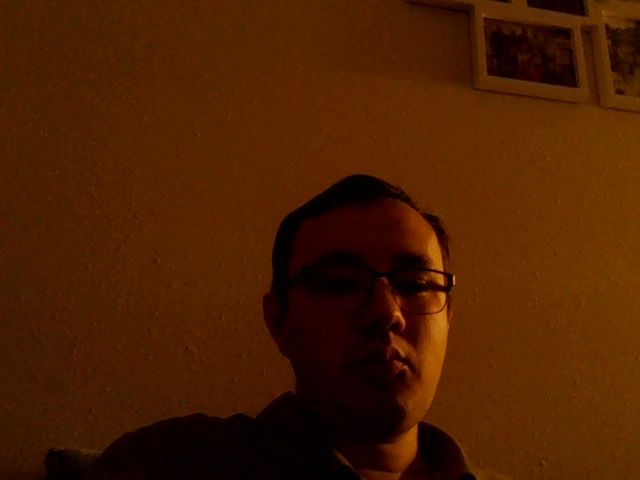

In [7]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

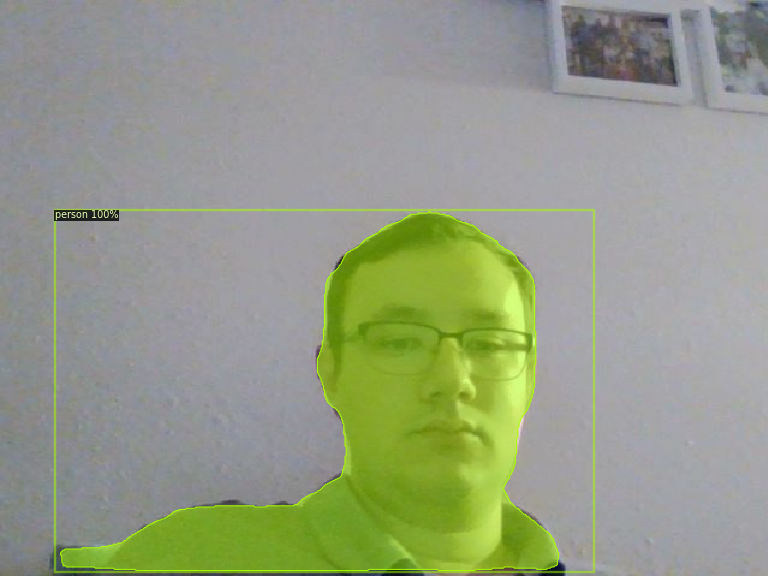

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [8]:
from google.colab import output
while True:
  filename = take_photo()
  cfg = get_cfg()
  im = cv2.imread(filename)
  # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
  # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
  predictor = DefaultPredictor(cfg)
  outputs = predictor(im)
  output.clear()
  # We can use `Visualizer` to draw the predictions on the image.
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
# Copied from: https://github.com/facebookresearch/detectron2/blob/master/demo/predictor.py
import atexit
import bisect
import multiprocessing as mp
from collections import deque

import cv2
import torch

from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer


class VisualizationDemo(object):
    def __init__(self, cfg, instance_mode=ColorMode.IMAGE, parallel=False):
        """
        Args:
            cfg (CfgNode):
            instance_mode (ColorMode):
            parallel (bool): whether to run the model in different processes from visualization.
                Useful since the visualization logic can be slow.
        """
        self.metadata = MetadataCatalog.get(
            cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
        )
        self.cpu_device = torch.device("cpu")
        self.instance_mode = instance_mode

        self.parallel = parallel
        if parallel:
            num_gpu = torch.cuda.device_count()
            self.predictor = AsyncPredictor(cfg, num_gpus=num_gpu)
        else:
            self.predictor = DefaultPredictor(cfg)

    def run_on_image(self, image):
        """
        Args:
            image (np.ndarray): an image of shape (H, W, C) (in BGR order).
                This is the format used by OpenCV.
        Returns:
            predictions (dict): the output of the model.
            vis_output (VisImage): the visualized image output.
        """
        vis_output = None
        predictions = self.predictor(image)
        # Convert image from OpenCV BGR format to Matplotlib RGB format.
        image = image[:, :, ::-1]
        visualizer = Visualizer(image, self.metadata, instance_mode=self.instance_mode)
        if "panoptic_seg" in predictions:
            panoptic_seg, segments_info = predictions["panoptic_seg"]
            vis_output = visualizer.draw_panoptic_seg_predictions(
                panoptic_seg.to(self.cpu_device), segments_info
            )
        else:
            if "sem_seg" in predictions:
                vis_output = visualizer.draw_sem_seg(
                    predictions["sem_seg"].argmax(dim=0).to(self.cpu_device)
                )
            if "instances" in predictions:
                instances = predictions["instances"].to(self.cpu_device)
                vis_output = visualizer.draw_instance_predictions(predictions=instances)

        return predictions, vis_output

    def _frame_from_video(self, video):
        while video.isOpened():
            success, frame = video.read()
            if success:
                yield frame
            else:
                break

    def run_on_video(self, video):
        """
        Visualizes predictions on frames of the input video.
        Args:
            video (cv2.VideoCapture): a :class:`VideoCapture` object, whose source can be
                either a webcam or a video file.
        Yields:
            ndarray: BGR visualizations of each video frame.
        """
        video_visualizer = VideoVisualizer(self.metadata, self.instance_mode)

        def process_predictions(frame, predictions):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if "panoptic_seg" in predictions:
                panoptic_seg, segments_info = predictions["panoptic_seg"]
                vis_frame = video_visualizer.draw_panoptic_seg_predictions(
                    frame, panoptic_seg.to(self.cpu_device), segments_info
                )
            elif "instances" in predictions:
                predictions = predictions["instances"].to(self.cpu_device)
                vis_frame = video_visualizer.draw_instance_predictions(frame, predictions)
            elif "sem_seg" in predictions:
                vis_frame = video_visualizer.draw_sem_seg(
                    frame, predictions["sem_seg"].argmax(dim=0).to(self.cpu_device)
                )

            # Converts Matplotlib RGB format to OpenCV BGR format
            vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
            return vis_frame

        frame_gen = self._frame_from_video(video)
        if self.parallel:
            buffer_size = self.predictor.default_buffer_size

            frame_data = deque()

            for cnt, frame in enumerate(frame_gen):
                frame_data.append(frame)
                self.predictor.put(frame)

                if cnt >= buffer_size:
                    frame = frame_data.popleft()
                    predictions = self.predictor.get()
                    yield process_predictions(frame, predictions)

            while len(frame_data):
                frame = frame_data.popleft()
                predictions = self.predictor.get()
                yield process_predictions(frame, predictions)
        else:
            for frame in frame_gen:
                yield process_predictions(frame, self.predictor(frame))


class AsyncPredictor:
    """
    A predictor that runs the model asynchronously, possibly on >1 GPUs.
    Because rendering the visualization takes considerably amount of time,
    this helps improve throughput a little bit when rendering videos.
    """

    class _StopToken:
        pass

    class _PredictWorker(mp.Process):
        def __init__(self, cfg, task_queue, result_queue):
            self.cfg = cfg
            self.task_queue = task_queue
            self.result_queue = result_queue
            super().__init__()

        def run(self):
            predictor = DefaultPredictor(self.cfg)

            while True:
                task = self.task_queue.get()
                if isinstance(task, AsyncPredictor._StopToken):
                    break
                idx, data = task
                result = predictor(data)
                self.result_queue.put((idx, result))

    def __init__(self, cfg, num_gpus: int = 1):
        """
        Args:
            cfg (CfgNode):
            num_gpus (int): if 0, will run on CPU
        """
        num_workers = max(num_gpus, 1)
        self.task_queue = mp.Queue(maxsize=num_workers * 3)
        self.result_queue = mp.Queue(maxsize=num_workers * 3)
        self.procs = []
        for gpuid in range(max(num_gpus, 1)):
            cfg = cfg.clone()
            cfg.defrost()
            cfg.MODEL.DEVICE = "cuda:{}".format(gpuid) if num_gpus > 0 else "cpu"
            self.procs.append(
                AsyncPredictor._PredictWorker(cfg, self.task_queue, self.result_queue)
            )

        self.put_idx = 0
        self.get_idx = 0
        self.result_rank = []
        self.result_data = []

        for p in self.procs:
            p.start()
        atexit.register(self.shutdown)

    def put(self, image):
        self.put_idx += 1
        self.task_queue.put((self.put_idx, image))

    def get(self):
        self.get_idx += 1  # the index needed for this request
        if len(self.result_rank) and self.result_rank[0] == self.get_idx:
            res = self.result_data[0]
            del self.result_data[0], self.result_rank[0]
            return res

        while True:
            # make sure the results are returned in the correct order
            idx, res = self.result_queue.get()
            if idx == self.get_idx:
                return res
            insert = bisect.bisect(self.result_rank, idx)
            self.result_rank.insert(insert, idx)
            self.result_data.insert(insert, res)

    def __len__(self):
        return self.put_idx - self.get_idx

    def __call__(self, image):
        self.put(image)
        return self.get()

    def shutdown(self):
        for _ in self.procs:
            self.task_queue.put(AsyncPredictor._StopToken())

    @property
    def default_buffer_size(self):
        return len(self.procs) * 5

In [ ]:
Visualizer = VisualizationDemo(cfg)
Visualizer.run_on_video(cv2.VideoCapture)